#VICO Spring Week 4 Practical: Homographies

Required imports and download the image we'll be working with.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# Download the image we're going to work with
!wget https://www.cs.york.ac.uk/cvpr/VICO/prince.jpg

--2023-02-07 18:35:22--  https://www.cs.york.ac.uk/cvpr/VICO/prince.jpg
Resolving www.cs.york.ac.uk (www.cs.york.ac.uk)... 144.32.128.40
Connecting to www.cs.york.ac.uk (www.cs.york.ac.uk)|144.32.128.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80524 (79K) [image/jpeg]
Saving to: ‘prince.jpg’

prince.jpg          100%[===================>]  78.64K  --.-KB/s    in 0.01s   

2023-02-07 18:35:23 (5.87 MB/s) - ‘prince.jpg’ saved [80524/80524]



##Part 1: Correcting perspective projection

In the lecture on Monday, I took an oblique photograph of a planar surface (the cover of the Simon Prince textbook!) The first exercise is to use a homography and very basic backwards warping to perspective correct this image, i.e. create a version that looks as if it was taken exactly parallel to the book cover.

Let's start by loading and visualising the image.

(533, 400, 3)


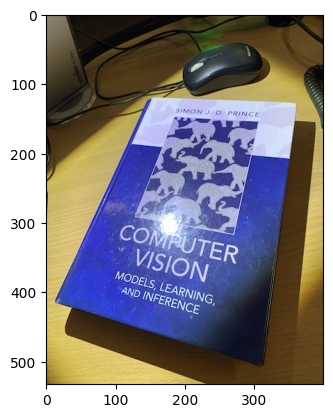

In [2]:
# Load image using OpenCV, convert to RGB and floating point between 0 and 1
img = cv2.cvtColor(cv2.imread('prince.jpg'), cv2.COLOR_BGR2RGB).astype('float32')/255

# Display image
plt.imshow(img)

print(img.shape)

The goal is to map the four corners of the book onto the four corners of a normalised rectangle (which has 4:3 aspect ratio, e.g. if the normalised rectangle was 400 pixels high, it would be 300 pixels wide).

To find a homography, we need to know some corresponding points - i.e. coordinates in the source image and the corresponding coordinates in the target image. I have clicked on the four corners of the book, starting with the top left corner and going in a clockwise order. Let's start by defining the source points and plotting them on top of the image. We use a coordinate system in which the origin is the top left pixel, i.e. the y coordinate is measured from the top (think of it as the "row" of the image or array/matrix) and the x coordinate is measured from the left (think of it as the "column" of the image).

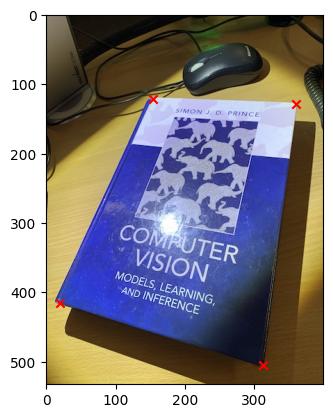

In [3]:
sourcepts = np.array([[154.0,121.0],[360.0,129.0],[312.0,504.0],[19.0,416.0]])
plt.imshow(img)
plt.scatter(sourcepts[:,0],sourcepts[:,1],marker="x",c="red")

Now let's visualise the target points, i.e. the normalised rectangle that we'd like to map the book onto.

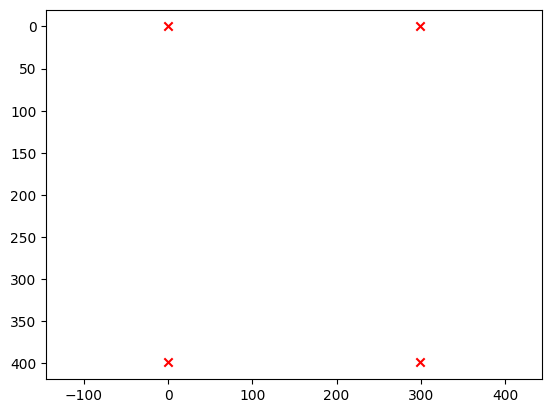

In [4]:
targetpts = np.array([[0.0,0.0],[299.0,0.0],[299.0,399.0],[0.0,399.0]])
plt.scatter(targetpts[:,0],targetpts[:,1],marker="x",c="red")
# Set x and y axis scales equal and flip y axis to image coordinate system
plt.axis('equal')
plt.gca().invert_yaxis()

###Task 1: Computing a homography

Now it's time to actually compute a homography.

Suppose that $(x_{\text{source}},y_{\text{source}})$ is one of the points given in the source image which corresponds with $(x_{\text{target}},y_{\text{target}})$ in the output target image. Our goal is to find the $3\times 3$ homography matrix $\mathbf{H}$ such that:
$$
\lambda \begin{bmatrix}x_{\text{target}}\\y_{\text{target}}\\1\end{bmatrix} \approx \mathbf{H}\begin{bmatrix}x_{\text{source}}\\y_{\text{source}}\\1\end{bmatrix}
$$
i.e. that approximately maps each source point to its corresponding target point. We do this using homogeneous linear least squares as shown on Slide 7 of Week 4 Video 4 slides.

In [30]:
npts = sourcepts.shape[0]

# Initialise matrix with zeros, two equations (rows) per point, 9 columns (for each element of the H matrix)
A = np.zeros((2*npts,9))
for i in range(npts):
  u, v = sourcepts[i,0], sourcepts[i,1]
  x, y = targetpts[i,0], targetpts[i,1]
  A[2*i,:] = [0, 0, 0, -u, -v, -1, y*u, y*v, y]
  A[2*i+1,:] = [u, v, 1, 0, 0, 0, -x*u, -x*v, -x]

# Your code goes here: compute SVD of A
# Note: if you use np.linalg.svd, vh is already transposed, i.e. A = u @ S @ vh where S is built from elements in s
# Your code goes here: copy elements in the last row of vh into 3x3 matrix H

u, s, vh = np.linalg.svd(A)
H = vh[-1, :].reshape(3, 3)
H

array([[ 4.00759754e-03,  1.83398531e-03, -8.39082243e-01],
       [-1.83662969e-04,  4.72932144e-03, -5.43963797e-01],
       [ 1.70705371e-06,  4.63660598e-06,  1.59749560e-03]])

Let's check if the $\mathbf{H}$ you've estimated actually works! We can apply it to each source point and compare to the corresponding target point

In [73]:
for i in range(npts):
  # Apply H to column vector containing homogeneous coordinate for source point
  xy = H @ np.array([[sourcepts[i,0]],[sourcepts[i,1]],[1]])
  # Homogenise to get pixel coordinate
  x = xy[0]/xy[2]
  y = xy[1]/xy[2]
  # Display comparison
  print('True target point',i,targetpts[i,:])
  print('Estimated target point',i,x,y)

True target point 0 [108 144]
Estimated target point 0 [108.54666954] [144.61586756]
True target point 1 [315 210]
Estimated target point 1 [314.48373251] [210.42977575]
True target point 2 [320 147]
Estimated target point 2 [320.21278249] [146.58362806]
True target point 3 [ 76 272]
Estimated target point 3 [75.71147825] [271.75649466]
True target point 4 [309 358]
Estimated target point 4 [309.24860329] [357.9275104]
True target point 5 [ 55 106]
Estimated target point 5 [54.78291667] [105.67901068]


Because we only have four points (which is the minimum) the solution should fit the data exactly (up to some very small numerical error).

###Task 2: Basic backwards warping

Now for the tricky part. We want to warp the source image onto the target. We're going to do this by hand using a very basic strategy (there are built in functions to do this but you'll learn more doing it by hand first). 

We have computed the homography, $\mathbf{H}$, that maps source points to target points. Intuitively, you might now think that you will apply this to the coordinate of every pixel in the source image and that will give you a target coordinate along the colour that you need to paint in the target image. The problem with this approach is that you end up with irregularly sampled output points (i.e. the warped coordinates are at non-integer positions).

In fact, the standard technique is *backwards warping*. What this means is that we instead apply $\mathbf{H}^{-1}$ to each pixel coordinate in the output image, and then look up the colour in the source image at this point. Usually, this would be done by interpolation but we'll do something much simpler and just use the nearest neighbour. Specifically, I want you to implement the following algorithm:

*   $I_{\textrm{source}}$ is an image of size $H_{\textrm{source}}=533$ by $W_{\textrm{source}}=400$ so that $I_{\textrm{source}}(y,x)$ gives the colour at pixel $(x,y)$ (notice reversed order since OpenCV/NumPy use row,column ordering).
*   We wish to compute $I_{\textrm{target}}$ of size $H_{\textrm{target}}=400$ by $W_{\textrm{target}}=300$
*   For every pixel $(x_{\text{target}},y_{\text{target}})$ in the output image: 
   * Apply the homography $\mathbf{H}^{-1}$ to $(x_{\text{target}},y_{\text{target}})$
   * Round the transformed pixel coordinate to get $(x_{\text{round}},y_{\text{round}})$
   * If $0\leq x_{\text{round}} < W_{\textrm{source}}$ and $0\leq y_{\text{round}} < H_{\textrm{source}}$:
      * Copy colour from $I_{\textrm{source}}(y_{\text{round}},x_{\text{round}})$ to $I_{\textrm{target}}(y_{\text{target}},x_{\text{target}})$ 



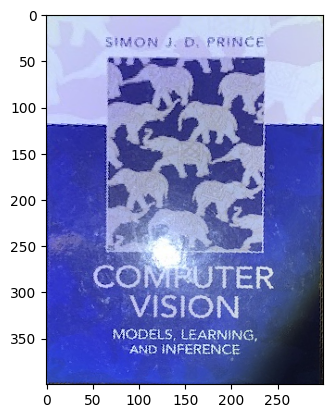

In [49]:
H_source = img.shape[0]
W_source = img.shape[1]
H_target = 400
W_target = 300
# Initialise output image with all zeros
output = np.zeros((H_target,W_target,3))

H_inv = np.linalg.inv(H)

# Loop over all pixels in output image
for row in range(H_target):
  for col in range(W_target):
    xy = np.atleast_2d([col, row, 1]).T
    xy = H_inv @ xy
    x = int(np.round(xy[0]/xy[2]))
    y = int(np.round(xy[1]/xy[2]))
    if 0 <= x < W_source and 0 <= y < H_source:
      output[row, col, :] = img[y, x, :]


# Display image
plt.imshow(output)

##Part 2: panoramic stitching

The second task is more open-ended. I would like you to stitch two images into a panorama. I would like you to use your own images for this. Use your phone to take two photos where you rotate the camera between images (try to keep the camera's centre in the same position as you rotate). You might want to resize your images to a reasonable size (maybe 400-600 pixels along the longer side) before you start. You will then need to manually label at least four corresponding point pairs (more than four will be more robust). You could, for example, use an online tool like [this one](https://www.mobilefish.com/services/record_mouse_coordinates/record_mouse_coordinates.php) to do this. If you don't want to use your own dataset, the following code tile will download my image pair and define some manual point correspondences.

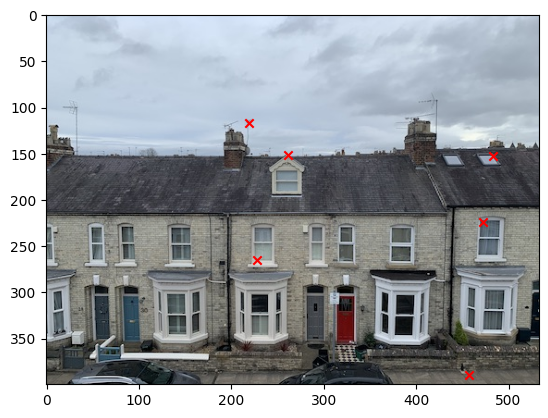

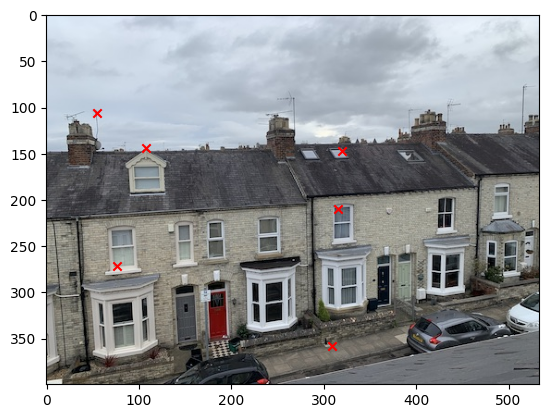

In [86]:
# IF YOU DON"T WANT TO USE YOUR OWN IMAGES
# Download an image pair
# !wget https://www.cs.york.ac.uk/cvpr/VICO/pano1.jpg
# !wget https://www.cs.york.ac.uk/cvpr/VICO/pano2.jpg
# Manual point correspondences

targetpts = np.array([[261,151],[472,224],[483,152],[228,265],[457,389],[219,117]])
sourcepts = np.array([[108,144],[315,210],[320,147],[76,272],[309,358],[55,106]])

# Load images
imageA = cv2.cvtColor(cv2.imread('pano1.jpg'), cv2.COLOR_BGR2RGB).astype('float32')/255
imageB = cv2.cvtColor(cv2.imread('pano2.jpg'), cv2.COLOR_BGR2RGB).astype('float32')/255
# Display original images
plt.imshow(imageA)
plt.scatter(targetpts[:,0],targetpts[:,1],marker="x",c="red")
plt.show()
plt.imshow(imageB)
plt.scatter(sourcepts[:,0],sourcepts[:,1],marker="x",c="red")


In [87]:
npts = sourcepts.shape[0]
A = np.zeros((2*npts,9))

for i in range(npts):
  u, v = sourcepts[i,0], sourcepts[i,1]
  x, y = targetpts[i,0], targetpts[i,1]
  A[2*i,:] = [0, 0, 0, -u, -v, -1, y*u, y*v, y]
  A[2*i+1,:] = [u, v, 1, 0, 0, 0, -x*u, -x*v, -x]
  
u, s, vh = np.linalg.svd(A)
H = vh[-1, :].reshape(3, 3)
H

array([[-3.05565779e-03,  2.36961981e-04, -9.86773960e-01],
       [ 6.80799428e-04, -4.52824610e-03, -1.61918725e-01],
       [ 4.36149749e-06,  1.63430471e-08, -5.39590779e-03]])

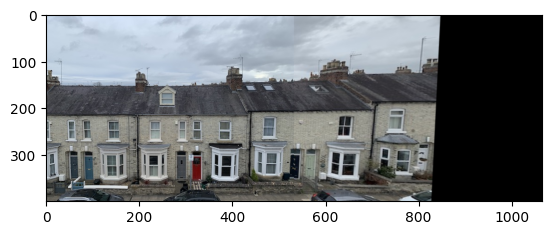

In [93]:
H_source = imageA.shape[0]
W_source = imageA.shape[1]
H_target = imageB.shape[0]
W_target = imageB.shape[1]

res = cv2.warpPerspective(imageB, H, (W_source + W_target, H_target))
res[:imageA.shape[0], :imageB.shape[1]] = imageA
plt.figure()
plt.imshow(res)

###Task 3: stitch the panorama

First, compute the best fitting homography from one image to another using the code you wrote above and the corresponding points you just labelled (or use mine above).

Second, warp image B into the perspective of image A. This time we'll use a built in openCV function to do this in a more sophisticated way than our image above: `cv2.warpPerspective`. You have to define the dimensions of the output warped image. A reasonable idea might be to make the output size twice as wide as the original images (assuming you rotated sideways).

Third, combine the warped image B with image A. The easiest way to do this is to overwrite pixels that are covered by image A with image A. e.g. if you made the output twice as wide, you can just overwrite the left half of the image with image A. A more sophisticated alternative is to average A and warped B in pixels where both are defined, otherwise just take whichever has a defined value.